# CNNs for Dachshund Detection in TensorFlow

1. [Data preparation](#1)
2. [Simple CNN](#2)
3. [ResNet](#3)
4. [EfficientNet](#4)<br>
    4.1 [Fine-tuning](#4-1)<br>
    4.2 [Saving and loading EfficientNet](#4-2)
5. [Visualising convolutional networks](#5)<br>
    5.1 [Class saliency maps](#5-1)<br>
    5.2 [Object localisation](#5-2)<br>
    5.3 [Class model visualisation](#5-3)<br>
6. [Quantisation for deployment](#6)
    
We want to investigate various convolutional neural networks for the purpose of distinguishing dachshunds from other dog breeds. Our ultimate goal is to build a lightweight model and deploy it to Heroku with Flask with a simple frontend where users can upload their own images and see the result of the classification. You can try out the finished product at [https://doxie-detector.herokuapp.com](https://doxie-detector.herokuapp.com) (note: the initial boot-up can take a while on Heroku's free tier). The current notebook is continuation from [linear_models.ipynb](linear_models.ipynb), where we applied classical linear methods to obtain a baseline accuracy for our problem. By utilising principal component analysis and support vector machines we achieved 61.2% validation accuracy. We now want to see how much we can improve on this with more sophisticated models.

The plan for the rest of the notebook is as follows. We'll first briefly overview the dataset and prepare it for usage in Keras models. Then, we'll train a simple CNN from scratch, which gives us a modest improvement in terms of accuracy. To further improve on this we perform transfer learning on existing models, namely ResNet and EfficientNet. This allows us to obtain a decent accuracy of ~93.6% without much effort. We then investigate the finished model with the help of saliency maps and class activation maps. Finally, we also present a novel simple algorithm for object localisation based on saliency maps, which does not require any further input from the network.

## 1. Data preparation<a id='1'></a>

Our datasets consists of 2129 pictures of dachshunds and dogs of other breeds spread roughly evenly across both classes. All of the pictures were scraped from various public sources such as [Dog API](https://dog.ceo/dog-api/) and reddit. The only constraint for the selected images was that each should contain exactly one dog (at least partially visible). No preprocessing or pruning of any kind was done, so the dataset includes plenty of out of focus photos, poorly cropped or centred pictures or photos where only a small part of the dog is visible, to name just a few. So it is possible, for example, that a sample image doesn't show the face of the dog at all, which means that our model will have to learn to be very versatile. Moreover, some of the dogs have multiple pictures of themselves in our dataset which we expect will add extra noise to the validation accuracy.

We split these images into a train and validation set with a 80-20 split and resize each of them to 224x224 pixels. We do not use a proper test set, but instead investigate our final model with a few select images of family dogs (who are not present in the train or validation datasets at all).

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


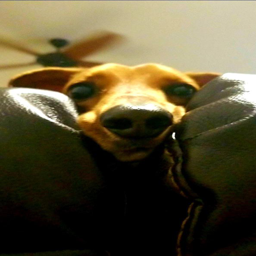

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import PIL
import PIL.Image
import pickle
import glob

print(tf.config.list_physical_devices('GPU'))
DATA_DIR = 'data'
dachshunds = ['data/dachshund/' + i for i in os.listdir('data/dachshund')
              if os.path.splitext(i)[1][1:] in ["jpeg", "jpg", "png"]]
PIL.Image.open(dachshunds[3]).resize((256,256))

We're training our models locally with only one GTX 1660 Ti 6GB. With the following cell we can limit TensorFlow's memory usage to 4GB in order to keep the system operational during training.

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
AUTO = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3

SEED = 0

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
class_names = ['other', 'dachshund']

train_ds_ = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_names=class_names
)

val_ds_ = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_names=class_names
)

test_ds_ = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    class_names=class_names
)

Found 2129 files belonging to 2 classes.
Using 1704 files for training.
Found 2129 files belonging to 2 classes.
Using 425 files for validation.
Found 8 files belonging to 2 classes.


In [5]:
cast_img = lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y)

train_ds = (train_ds_
            .map(cast_img)
            .cache()
            .prefetch(buffer_size=AUTO))
val_ds = (val_ds_
          .map(cast_img)
          .cache()
          .prefetch(buffer_size=AUTO))
test_ds = (test_ds_
           .map(cast_img)
           .cache()
           .prefetch(buffer_size=AUTO))

In [6]:
def plot_scores(hist, metric='accuracy', finetune=None, clamp_loss=None, smooth=0):
    y_lim = min(4., np.max(hist['loss']), np.max(hist['val_loss']))
    fig, axs = plt.subplots(1,2,figsize=(14,4))
    x=range(1,len(hist['loss'])+1)
    axs[0].plot(x,hist['loss'], label='loss')
    axs[0].plot(x,hist['val_loss'], label='val_loss')
    if clamp_loss:
        axs[0].set_ylim(*clamp_loss)

    
    axs[1].plot(x, hist[metric], label=metric)
    axs[1].plot(x, hist['val_'+metric], label='val_'+metric)
    if smooth > 0:
        axs[1].plot(x[smooth:],
                    np.convolve(hist['val_'+metric], np.ones(smooth)/smooth, mode='full')[smooth:len(x)],
                    label='val_'+metric+'_smooth', c='#7f7f7f', linestyle='--')

    for ax in axs:
        if finetune:
            ax.plot([finetune, finetune], ax.get_ylim(), label='start finetuning',scaley=False)
        ax.legend()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xlabel('Epoch')

    plt.show()

## 2. Simple CNN<a id='2'></a>

We first train a simple sequential CNN architecture from scratch. It is based on the [VGG16](https://arxiv.org/abs/1409.1556v6) network (see Configuration A in Table 1), but we reduce the size of the fully connected layers since our dataset is small and we only want to perform binary classification. To alleviate problems with high variance due to the small training set, we include regularisation in the form of some simple image augmentation steps and BatchNormalisation layers after each convolutional layer. As usual we also include 0.5 dropout for the fully connected top layers.

We use the Adam optimiser with `learning_rate=epsilon=0.001` for training. We see that after ~40 epochs we obtain a 70.3% accuracy which is roughly a 9 percent point improvement over our baseline at the cost of a much more complicated model.

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

In [8]:
model_simple = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    data_augmentation,
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.Rescaling(scale=1./255),

    # Block 1
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    # Block 2
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    # Block 3
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    # Block 4
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    # Block 5
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

In [9]:
print(f"{model_simple.count_params()/1e6:.1f} M parameters")

22.3 M parameters


In [10]:
base_lr = 0.001

early_stop = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
callbacks = [early_stop]

model_simple.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_lr, epsilon=1e-3),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
history_simple = model_simple.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[callbacks],
    verbose=True
)

Epoch 1/200
54/54 [==============================] - 72s 1s/step - loss: 2.6941 - binary_accuracy: 0.5306 - val_loss: 4.7720 - val_binary_accuracy: 0.4847
Epoch 2/200
54/54 [==============================] - 30s 559ms/step - loss: 3.0858 - binary_accuracy: 0.5237 - val_loss: 0.8158 - val_binary_accuracy: 0.5224
Epoch 3/200
54/54 [==============================] - 29s 545ms/step - loss: 2.2368 - binary_accuracy: 0.5348 - val_loss: 0.7357 - val_binary_accuracy: 0.5294
Epoch 4/200
54/54 [==============================] - 30s 553ms/step - loss: 1.5296 - binary_accuracy: 0.5262 - val_loss: 0.8043 - val_binary_accuracy: 0.4871
Epoch 5/200
54/54 [==============================] - 30s 557ms/step - loss: 1.4557 - binary_accuracy: 0.4861 - val_loss: 0.7116 - val_binary_accuracy: 0.4965
Epoch 6/200
54/54 [==============================] - 29s 537ms/step - loss: 1.0744 - binary_accuracy: 0.5536 - val_loss: 0.7192 - val_binary_accuracy: 0.5153
Epoch 7/200
54/54 [==============================] - 31

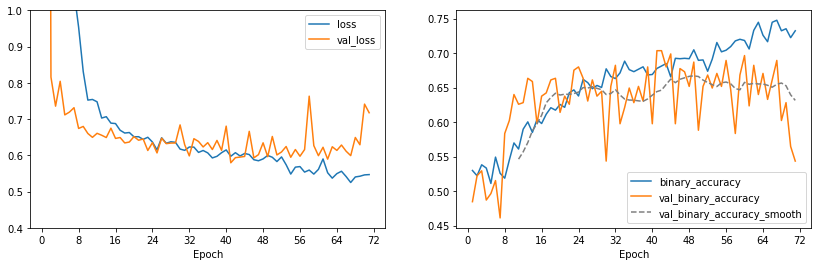

In [11]:
simple_hist = history_simple.history
plot_scores(simple_hist, 'binary_accuracy', clamp_loss=(0.4, 1), smooth=10)

In [12]:
model_simple.evaluate(val_ds, return_dict=True)

14/14 [==============================] - 2s 130ms/step - loss: 0.5794 - binary_accuracy: 0.7035


{'loss': 0.5794425010681152, 'binary_accuracy': 0.703529417514801}

The learning curves show that after about 50 epochs the model starts overfitting, but we recover the earlier model with less variance with early stopping. It seems plausible that with some more regularisation (e.g. adding dropout to each convolutional block) we could keep training and obtain improvements in accuracy. On the other hand, looking at the smoothed validation accuracy it is highly possible that the final 70% accuracy is just noise and the true (generalisation) accuracy of the model is somewhat lower. In the next section we will replace the convolutional part of our model with an existing network pretrained on the ImageNet dataset.

## 3. ResNet<a id='3'></a>
In order to improve on our sequential network, we next consider more sophisticated structures. Also, instead of training from scratch we use transfer learning with an existing network trained on the massive ImageNet dataset. Our first choice for such an architecture is ResNet, originally introduced by [He et al. (2015)](https://arxiv.org/pdf/1512.03385.pdf) (our particular version of this network is `tf.keras.applications.resnet_v2.ResNet50V2`, which is a moderate improvement over the original ResNet50 structure). In this seminal paper the authors introduced so-called *skip connections*, where the outputs of a convolutional block completely bypass the immediately following block and are directly added to the input of the subsequent block. On the one hand, this has a regularising effect allowing them to train much deeper networks than e.g. VGG since gradients are free to travel (without decaying) through the identity mappings of the skip connections. On the other hand, the deeper layers now have access to finer spatial info (in the form of features from earlier convolutional blocks with smaller fibres) allowing them to learn more complex features. All in all, ResNets vastly outperform the traditional convolutional networks.

Typically, when doing transfer learning, one extracts the trained bottom layers of the pretrained model and discards the final fully connected top layers. A new set of fully connected layers, customised to the particular task, is then attached to this pretrained base and only the weights of the new layers are modified during training. Since ImageNet-trained models learn a very rich set of features, we regularise our fully connected layers with a typical 0.5 dropout.

With this method we're able to obtain 88.4% accuracy in roughly 15 training epochs. This is not surprising since the ImageNet dataset already contains many pictures of dogs so the model is used to detecting them. The downside of our model is that it is rather huge both in terms of disk space and memory requirements at inference time. This unfortunately makes our initial attempt unwieldy for the purpose of deploying it directly to Heroku with Flask. We could circumvent this by setting up a TFServing server, for example, but typically it's more desirable to trim the "unnecessary fat" from models that we want deployed to production.

In [8]:
pretrained_base = tf.keras.applications.ResNet50V2(include_top=False,
                                                   weights='imagenet')
pretrained_base.trainable = False
preprocess_input_resnet = tf.keras.applications.resnet_v2.preprocess_input

model_resnet = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    data_augmentation,
    layers.Lambda(preprocess_input_resnet),
    
    pretrained_base,
    
    layers.Flatten(),
    layers.Dense(512),
    layers.Dropout(0.5),
    layers.Dense(512),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')
])

In [9]:
base_learning_rate = 0.001

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['binary_accuracy'],
)

In [10]:
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=False
)

In [11]:
model_resnet.evaluate(val_ds, return_dict=True)

14/14 [==============================] - 1s 104ms/step - loss: 1.6888 - binary_accuracy: 0.8847


{'loss': 1.688774824142456, 'binary_accuracy': 0.8847059011459351}

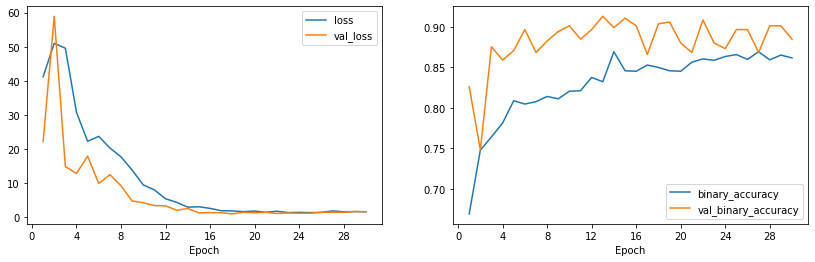

In [12]:
resnet_hist = history_resnet.history
plot_scores(resnet_hist, 'binary_accuracy')

We clearly see how the model manages to avoid overfitting with help from the dropout layers and converges to a stable state. Let's see what the model predicts for our test pictures.

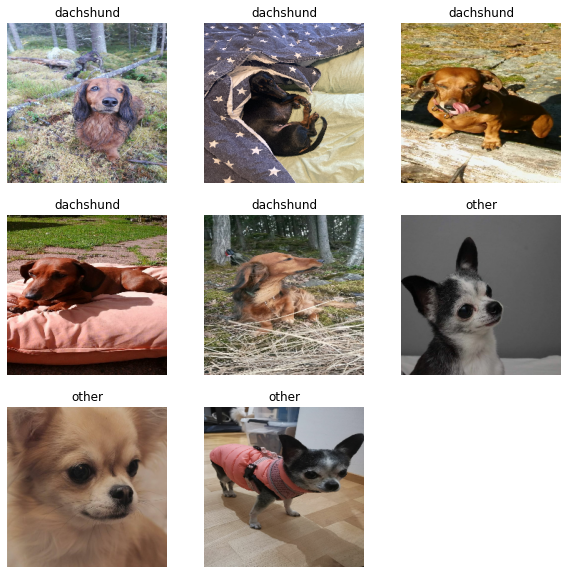

In [13]:
predictions = (model_resnet.predict(test_ds) > 0.5).ravel().astype(int)

plt.figure(figsize=(10, 10))
for image, label in test_ds.take(1):
    for i in range(len(predictions)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(f"{class_names[predictions[i]]}")
        plt.axis(False)

All our family dogs got appropriately classified! In the next section we decrease the size of our model by using a more recent architecture tailor-made for mobile and edge devices. It contains vastly less weights, despite offering comparable (or even better) performance. Let's see whether this will be enough for our purposes.

## 4. EfficientNet<a id='4'></a>
EfficientNet ([Tan and Le, 2020](https://arxiv.org/abs/1905.11946)) was, at the time of its introduction, somewhat of a culmination of the evolution of multiple convolutional architectures. It did not introduce new ways to arrange layers or move around the network, per se, but focused more on various aspects of optimisation that had fallen to the sidelines with new innovative CNN models appearing almost every year. Their key idea was to realise that instead of treating existing architectures as fixed, they should be scaled with various parameters (depth, width and resolution) in a controlled manner based on the task at hand. In the paper the authors applied this technique to many existing networks drastically reducing the number of parameters while retaining comparative performance. In particular, they introduced a series of optimised networks, called `EfficientNetB0`-`EfficientNetB7`, where the complexity grows from `B0` to `B7` and each network had been tuned with their methodology.

For our problem we pick one of the smaller networks, namely, `B1`. To further reduce the complexity, we replace the fully connected final layers that we used with ResNet by *global average pooling*. Global average pooling was introduced by Lin et al. as a part of their paper [Network in Network](https://arxiv.org/pdf/1312.4400v3.pdf) (2014). This type of layer simply compresses each filter from the previous convolutional layer by computing its mean. The intuition for this was that the pooling layer retains some of the original spatial structure which would normally be lost after flattening. Moreover, such a layer has no weights to train (because we are just taking an average over each individual filter) which helps against overfitting. GAP also makes the network smaller, because usually it is the final fully connected layers of a CNN which contain the majority of the model's weights.

In [8]:
def build_model(base_lr = 0.001):
    base_model_effnet = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False,
                                                                          weights='imagenet')
    base_model_effnet.trainable = False
    preprocess_input_effnet = tf.keras.applications.efficientnet.preprocess_input

    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
        data_augmentation,
        layers.Lambda(preprocess_input_effnet),
    
        base_model_effnet,
    
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(1),
        layers.Activation('sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=base_lr),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['binary_accuracy']
    )
    
    return model

In [9]:
model_effnet = build_model()

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(patience=7)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, restore_best_weights=True)
callback = [lr_reduce, early_stopping]

history_effnet = model_effnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    callbacks=callback,
    verbose=False
)

In [10]:
model_effnet.evaluate(val_ds, return_dict=True)

14/14 [==============================] - 2s 116ms/step - loss: 0.1846 - binary_accuracy: 0.9318


{'loss': 0.18463800847530365, 'binary_accuracy': 0.9317647218704224}

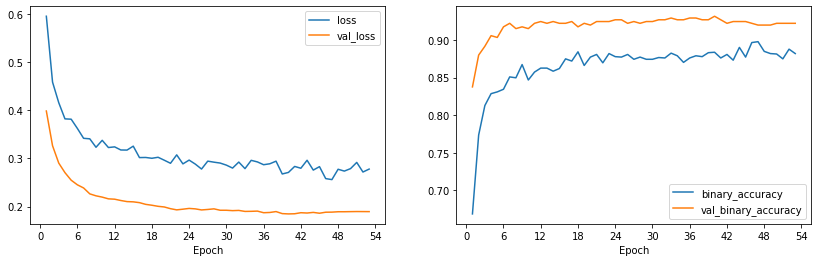

In [11]:
effnet_hist = history_effnet.history
plot_scores(effnet_hist, 'binary_accuracy')

We obtain a good improvement over what we had with ResNet. Notice that we also train for a lot longer even though the validation accuracy quickly reaches a fairly stable level around 93%. This is because we want to attempt to further increase the accuracy by fine-tuning our model and for this it's important that the top layers have fully converged before we unfreeze any weights. If the final layers were unstable we would risk throwing the pretrained weights of the newly unfrozen layers off-balance as they would have to adjust to large backpropagated gradients.

### 4.1 Fine-tuning<a id='4-1'></a>
We can see below that the EfficientNet network consists of several stages, which each contain a number of convolutional blocks (see Table 1 in the paper). We will unfreeze only the last block of the last stage and train with a much smaller learning rate of $10^{-6}$.

In [12]:
model_effnet.layers[2].summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [13]:
print(str(next(x for x, val in enumerate(model_effnet.layers[2].layers) if val.name == 'block7b_expand_conv')))

321


In [14]:
model_effnet.layers[2].trainable = True

fine_tune_from = 321

for layer in model_effnet.layers[2].layers[:fine_tune_from]:
    layer.trainable = False
    
for layer in model_effnet.layers[2].layers[fine_tune_from:]:
    if layer.name[-3:] == "_bn":
        layer.trainable = False
        print(f"Layer {layer.name} won't be trained.")
    
model_effnet.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['binary_accuracy'],
)

initial_epochs = len(history_effnet.epoch)
finetune_epochs = 40
total_epochs = initial_epochs + finetune_epochs

history_fine = model_effnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_effnet.epoch[-1],
    verbose=False
)

Layer block7b_expand_bn won't be trained.
Layer block7b_bn won't be trained.
Layer block7b_project_bn won't be trained.
Layer top_bn won't be trained.


In [15]:
model_effnet.evaluate(val_ds, return_dict=True)

14/14 [==============================] - 2s 119ms/step - loss: 0.1572 - binary_accuracy: 0.9365


{'loss': 0.15715086460113525, 'binary_accuracy': 0.9364705681800842}

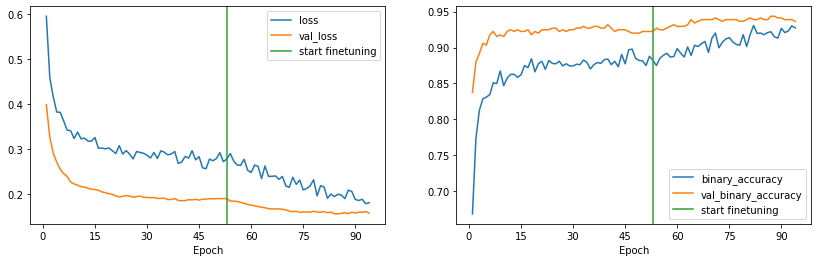

In [16]:
effnet_hist_fine = history_fine.history
plot_scores({key: val + effnet_hist_fine[key] for (key, val) in effnet_hist.items() if key in ['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy']}, 'binary_accuracy', finetune=initial_epochs)

We don't really see much gain in terms of accuracy, but there is a relative gain of ~15% in performance in terms of the loss. However, it seems that if we were to finetune for much further we would be at risk of overfitting. Hence, we'll call it a day and move on to investigate what our network has actually learnt. First though, let's quickly check the predictions for our test set again.

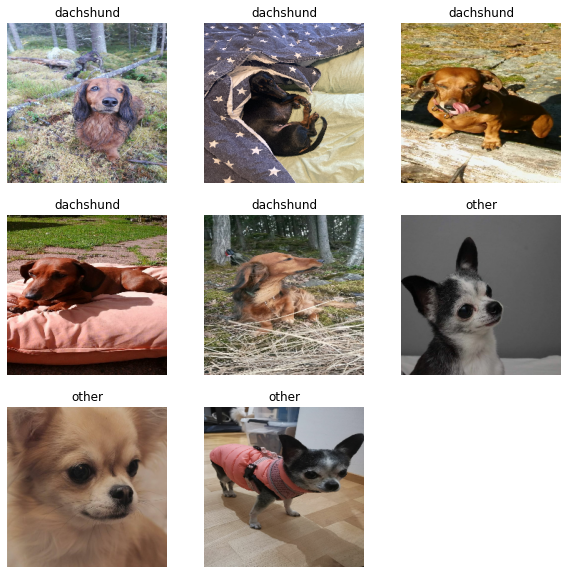

In [17]:
predictions = (model_effnet.predict(test_ds) > 0.5).ravel().astype(int)
plt.figure(figsize=(10, 10))
for image, label in test_ds.take(1):
    for i in range(len(predictions)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(f"{class_names[predictions[i]]}")
        plt.axis(False)

### 4.2 Saving and loading EfficientNet<a id='4-2'></a>

As a brief aside, there is currently a bug in Keras' implementation of EfficientNet and the `model.save_model` function when used with custom gradients. It is still possible to load the saved model and do inference (with a bunch of warnings thrown at you), but any further training has a possibility of failing. This issue is tracked at
https://github.com/tensorflow/tensorflow/issues/40166#issuecomment-756702752, where a workaround is also provided. Since we are finetuning our model, we have to modify the code slightly.

In [18]:
model_effnet.save_weights('model_effnet_weights.h5')
symbolic_weights = getattr(model_effnet.optimizer, 'weights')
weight_values = tf.keras.backend.batch_get_value(symbolic_weights)
with open('model_effnet_optimizer.pkl', 'wb') as f:
    pickle.dump(weight_values, f)

In [9]:
model_effnet = build_model()
model_effnet.layers[2].trainable = True
fine_tune_from = 321

for layer in model_effnet.layers[2].layers[:fine_tune_from]:
    layer.trainable = False
    
for layer in model_effnet.layers[2].layers[fine_tune_from:]:
    if layer.name[-3:] == "_bn":
        layer.trainable = False

model_effnet.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)

model_effnet.load_weights('model_effnet_weights.h5')
grad_vars = model_effnet.trainable_weights
zero_grads = [tf.zeros_like(w) for w in grad_vars]
model_effnet.optimizer.apply_gradients(zip(zero_grads, grad_vars))
with open('model_effnet_optimizer.pkl', 'rb') as f:
    weight_values = pickle.load(f)
model_effnet.optimizer.set_weights(weight_values)

## 5. Visualising convolutional networks<a id='5'></a>
Our final task is to investigate our model and to determine whether it has actually learnt what we would expect from it. There are multiple ways to do this including saliency maps, class activation maps, class model visualisation and inspection of specific filters based on image patches with the highest activation, to name just a few. For now, we'll focus on saliency maps and class model visualisation and leave the rest for future work. We'll also show how to use saliency maps to perform crude object localisation.

### 5.1 Class saliency maps<a id='5-1'></a>
Class saliency maps were introduced by [Simonyan et al.](https://arxiv.org/abs/1312.6034v2) (2014). The basic idea is simple: we compute the derivative of the output of our network with respect to the input. This tells us which pixels in the original image would have the largest effect on the output (i.e. the class posterior) if we were to alter them by a small amount. Since our pictures have 3 channels, we choose the max of the absolute values across the channels for each component of the derivative to get a single channel output.

Here is a simple implementation of the saliency map computation with the help of `tf.GradientTape`.

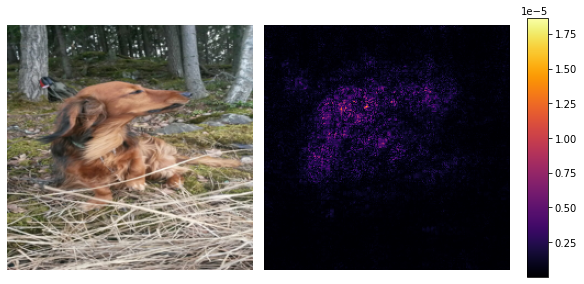

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

input_img = PIL.Image.open("test/dachshund/albert.jpg").resize((IMG_HEIGHT, IMG_WIDTH))


def saliency(img):
    x_sal = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
    x_sal = tf.expand_dims(x_sal, axis=0)

    with tf.GradientTape() as tape:
        tape.watch(x_sal)
        output = model_effnet(x_sal, training=False)

    gradients = tape.gradient(output, x_sal)
    g = np.absolute(gradients[0].numpy())
    g = np.max(g, axis=2)
    return g

g = saliency(input_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5), constrained_layout=True)
ax1.imshow(input_img)
ax1.axis(False)
im = ax2.imshow(g, cmap='inferno')
ax2.axis(False)
divider = make_axes_locatable(ax2)
box = ax2.get_position()
fig.colorbar(im, ax=ax2, shrink=0.72)
plt.show()

### 5.2 Object localisation<a id='5-2'></a>

In the original paper the authors mention how saliency maps can be used as part of a more sophisticated localisation algorithm (which falls far short of modern methods, though). The idea is that by thresholding on different quantiles of the saliency map distribution (30% and 95% to be exact), we can separate regions of the image into foreground and background pixels. Then, by fitting Gaussian mixture models to both parts, we obtain a probabilistic representation for either part of the picture. It is then possible to apply existing methods in computer vision to obtain good results. We won't go further into that here, but will simply show a quick example on how to fit the Gaussian models:

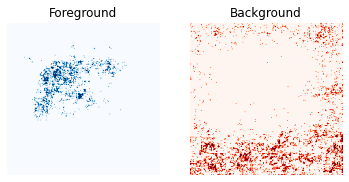

In [22]:
from sklearn.mixture import GaussianMixture

g = saliency(input_img)
grad = (g-g.min())/g.ptp()

g_95 = np.where(grad > np.quantile(grad, 0.95), grad, 0)
g_30 = np.where(grad < np.quantile(grad, 0.3), grad, 0)

fg_model = GaussianMixture(n_components=3, random_state=SEED)
fg_model.fit(g_95.reshape(-1,1))

bg_model = GaussianMixture(n_components=3, random_state=SEED)
bg_model.fit(g_30.reshape(-1,1))

fg_threshold = np.mean(fg_model.means_)
fg = grad > fg_threshold

bg_threshold = np.mean(bg_model.means_)
bg = grad < bg_threshold

plt.subplot(121)
plt.imshow(fg, cmap='Blues')
plt.title('Foreground')
plt.axis(False)
plt.subplot(122)
plt.imshow(bg, cmap='Reds')
plt.title('Background')
plt.axis(False)
plt.show()

What we want to do instead is a lot simpler. We'll treat the saliency map as a mass distribution over the original image and use it to find a bounding box, which captures an optimal portion of the total mass relative to its area. More precisely, we first compute the centre of mass of the full mass distribution, located at, say, `(c_x, c_y)`, and start fitting bounding boxes relative to it according to the following algorithm:

1. Fix the centroid `(c_x, c_y)` of a given saliency map.
2. Create a rectangle `R` with a *relative centre* `(c_x, c_y)` which fits the full image. By a relative centre we mean that if we adjust the width of any pair of sides of `R`, then `(c_x, c_y)` has to stay within the adjusted rectangle.
3. By picking one direction at a time (relative to the centroid: *left, right, top, bottom*) create a new rectangle `R'` by moving the chosen side of `R` perpendicularly towards its centroid so that the relative mass inside `R'` is `tol` of the total mass in `R` (a good default value for our data seems to be around `tol=0.90`).
4. Set `R:=R'` and continue from step 3. with the next chosen side.
5. After adjusting all 4 sides, output the final `R` as `R_final`.

Notice that the remaining total mass is adjusted in step 4. after the assignment. With this method we obtain quite stable bounding boxes from our saliency maps and they seem to be somewhat accurate as long as the classified object doesn't fully occupy the original image. To ensure stability, we also perform some additional smoothing in two ways: first, run the algorithm for each possible ordering of sides (i.e. we get 24 rectangles) and use their mean as `R_final`, and second, in step 3. we choose the final side length only after smoothing the curve for the change of mass (when moving that side).

We've created a simple class `Rect` (see [rel_rect.py](rel_rect.py)), which allows us to work with rectangles with a relative centre. The constructor of `Rect` takes 6 arguments `c_x, c_y, r_w, b_h, l_w, t_h`, i.e. the coordinates of the relative centre, right width of the rectangle, bottom height, left width and top height, respectively. The class then coerces the rectangle so that it is guaranteed to fit inside our initial image (of size 224x224) and exposes attributes `Rect.x_left`, `Rect.x_right`, `Rect.y_top` and `Rect.y_bot` for the coordinates of each of the sides. We can then adjust these sides separately with the methods `Rect.set_rw(r_w)`, `Rect.set_bh(b_h)` etc. After each adjustment the class automatically computes new values for all the properties of the rectangle.

In [23]:
from rel_rect import Rect

We need a simple function to compute the mass of the saliency map. This is nothing but the sum of the weights (which have been normalised to lie between 0 and 1) within the given rectangle. The function `get_mass` below takes a positional argument `x`, which is the full saliency map, and an optional keyword argument `r`, which is the rectangle whose mass we want to compute. If no rectangle is provided, we return the total mass of the saliency map.

In [24]:
def get_mass(x, r=None):
    if r is None:
        return np.sum(x)
    else:
        return np.sum(x.T[r.x_left : r.x_right + 1, r.y_top : r.y_bot + 1])

    
def get_density(x, r):
    return np.mean(x.T[r.x_left : r.x_right, r.y_top : r.y_bot])

We can then implement the algorithm we described as follows. It consists of three functions: `adjust_side`, `adjust_rec` and `fit_recs`. `adjust_side` does the brunt of the work. For a given rectangle it adjusts the location of the given side so that the relative mass is approximately equal to `tol` (after smoothing). Note that this adjustment is done *in place*. `adjust_rec` then simply calls `adjust_side` repeatedly for a given ordering of the sides for the inputted rectangle and returns *a new* rectangle, which is `R_final`. Finally, `fit_recs` is responsible for constructing the saliency map for a given input image, calling `adjust_rec` on it for all permutations of side orderings and for smoothing the final result.

In [25]:
from itertools import permutations


def adjust_side(x, rec, side, tol=0.9, smoothing=5):
    # modifies rec in place
    if not(side in ['r_w', 'l_w', 't_h', 'b_h']):
        raise ValueError("Invalid length name to Rectangle.")
    if rec is None:
        raise ValueError("Got empty Rectangle.")
    
    remaining_mass = get_mass(x, rec)
    lengths = np.arange(1, rec.__dict__[side] + 1)
    mass_prop = []
    
    # if we already have a minimal rect on this side
    if lengths is None:
        print("Got empty rec")
        return False

    func_name = {'r_w': 'set_rw', 'l_w': 'set_lw', 't_h': 'set_th', 'b_h': 'set_bh'}[side]
    adj = getattr(rec, func_name)
    
    for l in lengths:
        adj(l)
        mass_prop.append(get_mass(x, rec) / remaining_mass)
        
    # optional smoothing with a running average:
    if smoothing > 0 and len(mass_prop) > 0:
        smooth = min(smoothing, len(mass_prop))
        mass_prop = np.convolve(mass_prop, np.ones(smooth)/smooth, mode='full')[:len(mass_prop)]
    
    # find index where we retain tol% of the initial mass
    cutoff = np.argmax(np.array(mass_prop) > tol)
    adj(cutoff)
    
    return True


def adjust_rec(x, rec, sides=['r_w', 'l_w', 't_h', 'b_h'], tol=0.9, smooth=5):
    if rec is None:
        raise ValueError("Got empty Rectangle.")
    if not(set(sides) == set(['r_w', 'l_w', 't_h', 'b_h']) and len(sides) == 4):
        raise ValueError("Invalid length name to Rectangle.")
        
    # we modify a copy
    rec = Rect(rec.c_x, rec.c_y, rec.r_w, rec.b_h, rec.l_w, rec.t_h)
    
    for side in sides:
        adjust_side(x, rec, side, tol, smooth)
        
    return rec

    
def fit_recs(sal_img, tol=0.9, smooth=5):
    if sal_img is None:
        raise ValueError("Got empty sal_img.")
        
    # Normalise the map as per our assumptions
    x = (sal_img-sal_img.min())/np.ptp(sal_img)
    c_x = np.argmax(np.mean(x, axis=0))
    c_y = np.argmax(np.mean(x, axis=1))
    side_order = ['t_h', 'b_h', 'l_w', 'r_w']
    perms = permutations(side_order)
    
    # initialise the rec to max possible size irrespective of centroid loc
    full_rec = Rect(c_x, c_y, 223-c_x, 223-c_y, c_x, c_y)
    recs = []
    
    for p in perms:
        recs.append(adjust_rec(x, full_rec, p, tol=tol, smooth=smooth))
    
    # compute the final result as a mean of all the rectangles in 'recs'.
    r_w, l_w, t_h, b_h = 0, 0, 0, 0
    for r in recs:
        r_w += r.r_w
        l_w += r.l_w
        t_h += r.t_h
        b_h += r.b_h
    m = len(recs)
    r_w /= m
    l_w /= m
    t_h /= m
    b_h /= m
    final_rec = Rect(c_x, c_y, r_w, b_h, l_w, t_h)
    
    return recs, final_rec    

We can see the finished result below. The centroid is plotted as a red dot, each of the 24 `R_final` rectangles is drawn in red and finally their mean is shown in cyan. We'll see later that quite often the centroid is *not* located in what we would typically think of as the *centre* of the object (dog, in this case). However, based on our experiments, this does not in fact seem to be an issue and our final rectangles are fairly stable even if the centroid is very close to the edges. Moreover, our original reasoning for using this form of construction was to ensure a certain reasonable constraint for each rectangle, which should help with stability. We'll soon see that this is indeed what seems to have happened.

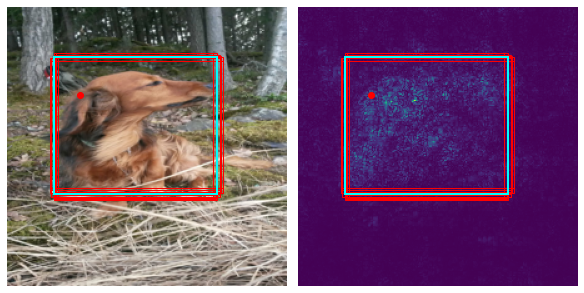

In [26]:
from matplotlib.patches import Rectangle


def plot_recs(ax, recs, final_rec):
    ax.scatter(final_rec.c_x, final_rec.c_y, c='r')
    for r in recs:
        ax.add_patch(Rectangle((r.x_left, r.y_top), r.w, r.h, color='red', fill=False))
    ax.add_patch(Rectangle((final_rec.x_left, final_rec.y_top), final_rec.w, final_rec.h,
                           color='cyan', fill=False, linewidth=2))

sal = saliency(input_img)
recs, final_rec = fit_recs(sal, 0.9, smooth=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5), constrained_layout=True)
ax1.imshow(input_img)
ax2.imshow(sal)
for ax in [ax1, ax2]:
    plot_recs(ax, recs, final_rec)
    ax.axis(False)
plt.show()

Here we see the algorithm applied to each image from our test set. It seems to provide reasonably good results except possibly when the target object occupies the whole image.

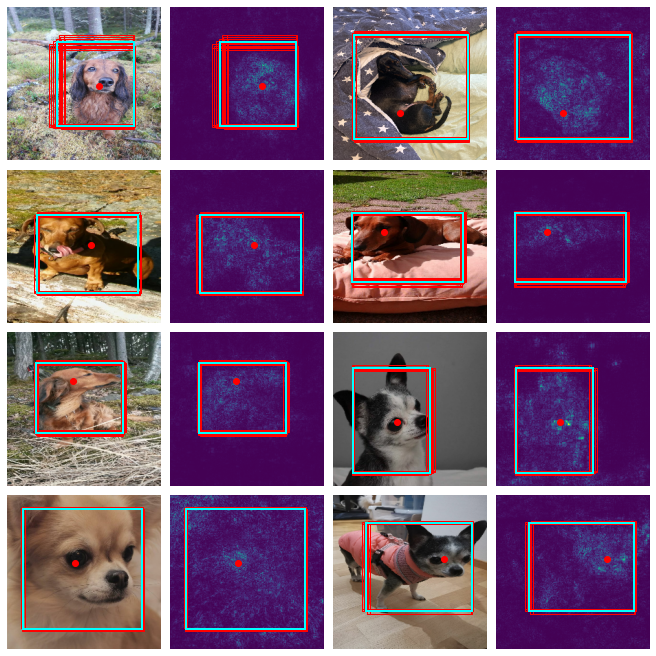

In [28]:
n_images = 8
tol = 0.9

n_rows = n_images // 2
n_cols = min(2 * n_images, 4)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(9, n_rows * 2.25), constrained_layout=True)
for img, _ in test_ds.take(1):
    for i in range(n_rows):
        for j in range(n_cols // 2):
            axs[i, 2*j].imshow(img[2*i+j].numpy().astype('uint8'))
            axs[i, 2*j].axis(False)
        
            sal = saliency(img[2*i+j].numpy())
            axs[i, 2*j+1].imshow(sal)
            axs[i, 2*j+1].axis(False)
        
            recs, final_rec = fit_recs(sal, tol, smooth=3)
            plot_recs(axs[i, 2*j], recs, final_rec)
            plot_recs(axs[i, 2*j+1], recs, final_rec)
        
plt.show()

There are multiple ways to improve this algorithm. One idea would be to use `np.grad` to incorporate the rate of change of mass as we adjust the sides, which would allow us to pick the threshold in a more controlled manner. We could also try to use the Gaussian mixtures model for the foreground and background pixels from last section and fit the bounding boxes based on that instead. It would also be interesting to investigate how our method would perform on a more complicated network trained on a bigger dataset (e.g. multiclass models on the ImageNet dataset).

### 5.3 Class model visualisation<a id='5-3'></a>

In the same [paper](https://arxiv.org/abs/1312.6034v2) the authors also discuss class model visualisation. The basic idea is to again take the gradient of the output with respect to the input and then modify (with gradient ascent) the input image so as to maximise the final class score. Ideally, this procedure should show us what the network perceives as a picture with maximal probability of being a dachshund. More precisely, our learning objective is the following. Denote by $\mathscr{I}$  the input image and let $S_c(\mathscr{I})$ be its linear class score (i.e. the output before sigmoid activation, so $S_c > 0$ corresponds to $c=\text{dachshund}$). We then want to find $\mathscr{I}$, which is a solution of the optimisation problem

$$\mathop{\mathrm{argmax}}_{\mathscr{I}}S_{c}(\mathscr{I}) - \lVert\mathscr{I}\rVert_{2}^{2},$$
where the additional $\ell_{2}$-regularisation ensures that the pixel values don't blow up and the final image stays somewhat smooth (by strongly penalising outliers). We do this by initialising $\mathscr{I}=\mathbf{0}$ and performing gradient ascent. We then add the mean $\mathscr{I}_{0}$ of the training set to the solution $\mathscr{I}$ to obtain our class visualisation.

Notice that it is important to use the class score and not the final activation. To see this, consider a multiclass classifier with softmax activation. The final output of such a network for a fixed class $c$ is $e^{S_c}/\sum_{c'}e^{S_{c'}}$. As pointed out in the paper, if we were to maximise this, we could do it simply by minimising the class score for all classes $c'\neq c$, which would not imply that the final image is representative of the features of class $c$. There seems to be an additional reason, which was not mentioned in the paper. In our case we only have 2 classes so the above is not a problem *a priori*. However, both softmax and sigmoid functions have the same issue that as the activation saturates the derivatives vanish (which is one of the reasons why most deep NNs have pivoted to ReLU activation in hidden layers). But this is precisely what we're optimising for and so if we were to use the class posteriors then it makes sense that the training would slow down considerably. Therefore, we remove the sigmoid activation and consider the linear output of our model instead.

In [10]:
model_effnet_linear = tf.keras.Model(inputs=model_effnet.input, outputs=model_effnet.layers[-2].output)

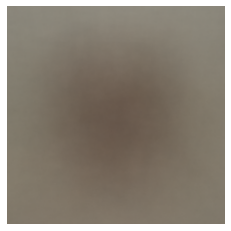

In [11]:
# Initialise I_0 to be the mean of the training set

I_0 = np.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS))
I_0 = tf.convert_to_tensor(I_0, dtype=tf.float32)
n = 0
for img, label in train_ds.unbatch():
    n += 1
    I_0 += img
I_0 /= n
plt.imshow(I_0.numpy().squeeze().astype('uint8'))
plt.axis(False)
plt.show()

We run the Adam optimiser for 3000 iterations with learning rate 0.3 and epsilon $10^{-12}$. Based on our experiments, it seems that the choice of optimisation algorithm seems to have a big effect on the visuals of the final image. Moreover, we obtain visually better results with the flag `training = True` since this keeps any BatchNormalisation layers active.

In [13]:
%%time
lbd = 0.01
lr = 0.3
I = tf.Variable(tf.zeros_like(I_0), name='I', dtype=tf.float32)

loss = lambda: -(model_effnet_linear(tf.expand_dims(I, axis=0), training=True)
                 - lbd * tf.math.reduce_sum(tf.math.square(I / 255.)))
opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-11)

steps = 3000
draw = False
save = True
save_freq = 10
save_folder = 'anim'
idx = 0
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

for i in range(steps):
    if save and i % save_freq == 0:
        img = PIL.Image.fromarray(tf.squeeze(I).numpy().astype('uint8'))
        img.save(os.path.join(save_folder, f'{idx:04}.png'), 'PNG')
        idx += 1
        
    if i % 10 == 9:    
        if draw:
            clear_output()
            plt.imshow(tf.squeeze(I).numpy().astype('uint8'))
            plt.axis(False)
            plt.show()
        print(f"{i+1}/{steps}", end="\r", flush=True)
    opt.minimize(loss, var_list=[I])
    tf.debugging.assert_all_finite(I, str(i))

Wall time: 14min 34s


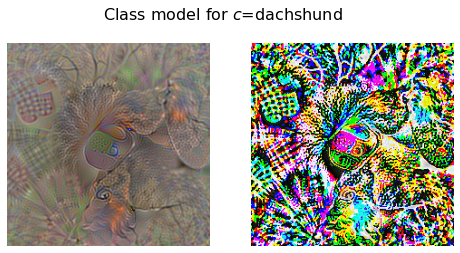

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(tf.squeeze(I+I_0).numpy().astype('uint8'))
ax1.axis(False)
ax2.imshow(tf.squeeze(I).numpy().astype('uint8'))
ax2.axis(False)
fig.suptitle('Class model for $c$=dachshund', fontsize=16)
plt.show()

On the right is the pure optimised image $\mathscr{I}$ (normalised) and on the left we have the final class model $\mathscr{I}+\mathscr{I}_{0}$. The results are not as pleasing as we expected (cf. the representations that they obtain in the original paper), but it is certainly possible to see that the model seems to be focusing a lot on the shape of the ears which are very unique to dachshunds. Below we show some other class model visualisations (which might present higher-level  features) for the dachshund class that were obtained with different training parameters:

![Class models for dachshunds](img/class_model_dachshund_title.png)

The results for the class "other", which contains a huge variety of breeds, are less pleasing:

![Class models for others](img/class_model_other_title.png)

Video of backpropagation for dachshund class model:<br><br>

<video width='448' height='224' controls src='https://nikolaaksonen.fi/anim_dachshund.mp4' type='video/mp4'>
</video>

In [16]:
model_effnet_linear.predict(tf.expand_dims(I, axis=0)).item()

38.9136962890625

Our complicated final image $\mathscr{I}$ obtains an extremely high linear score of ~38.9, which, after sigmoid activation, is equal to 1.0 to 16 decimal places. Notice that in the original paper the features of each particular class are more prominent in their class model visualisations. It is unclear whether this was generally true or if these examples were cherry-picked out of the 1000 classes. However, we present a few possible explanations as to why our results seem a bit different. First of all, as we pointed out above, the optimisation problem is extremely tricky. This is because we don't want to converge to just any local optimum, but one which provides us with some visible high-level features that humans can identify when looking at the picture. It is therefore difficult to find the right combination of hyperparameters to achieve this. Second, since we trained a model for a binary classification task between two very similar types of objects, it is plausible that our model focuses heavily on smaller details as opposed to what typical multiclass classifiers might do. It would be possible to determine whether this is indeed the case by examining which image patches activate which filters of the higher convolutional layers in our model. We'll leave that for future work. Another interesting avenue for investigation would be to see how the class models are affected if we keep other training parameters constant but initialise our image $\mathscr{I}$ with some mild (clamped) noise.

In the following cell we have the code we used to create the frames for the animation.

In [41]:
data_folder = 'anim/*png'
out_folder = 'anim_mu'
I_mu = tf.squeeze(I_0).numpy().astype('uint8')
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
*imgs, = [PIL.Image.open(f) for f in sorted(glob.glob(data_folder))]
imgs_mu = [PIL.Image.fromarray(np.array(i) + I_mu) for i in imgs]
for idx, img in enumerate(imgs_mu):
    comb_img = PIL.Image.new('RGB', (img.width * 2, img.height))
    comb_img.paste(img, (0, 0))
    comb_img.paste(imgs[idx], (img.width, 0))
    comb_img.save(os.path.join(out_folder, f'{idx:04}.png'), 'PNG')

# 6. Quantisation for deployment<a id='6'></a>

Now that we are satisfied with our model, it's time to deploy it to Heroku. Alas, even with all the simplifications we still end up going over the allotted RAM at inference time. In order to get around this, we quantise the model with `tf.life` to use a smaller precision. A typical default target is to convert the model to use `uint8`, but this is only optimised to run on ARM architecture. For Heroku we instead quantise to 16 bit floats. The final inference model ends up being only 22 MB in size, whereas the full model exported with ``tf.keras.models.save_model`` is well over 100 MB. As a comparison, the ResNet model takes about 42 MB even when quantised.

In [ ]:
import pathlib
curdir = pathlib.Path('.')
converter = tf.lite.TFLiteConverter.from_keras_model(model_effnet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()
tflite_model_quant_file = curdir/'-'
tflite_model_quant_file.write_bytes(tflite_quant_model)

In order to avoid using Heroku's finicky filesystem, we store the user uploaded file only in memory and pass it as a binary buffer to the html template. The complete inference process with the quantised model looks something like the following:

In [ ]:
from io import BytesIO
import base64 as b64

# When a new dyno is launched it loads the quantised model and gets the default signature with
interpreter_quant = tf.lite.Interpreter(model_path='-')
predict = interpreter_quant.get_signature_runner()

# We provide Flask with a function which captures POST requests to the website
# and loads the uploaded file to memory with
in_memory_data = BytesIO()
file.seek(0)
file.save(in_memory_data)
file.close()

# Since we want to display the picture to the user along with the result,
# we pass it as base 64 encoded string to the Jinja template
img = Image.open(in_memory_data).resize((img_height, img_width))
buffer = BytesIO()
img.save(buffer, 'JPEG')
encoded_img_data = b64.b64encode(buffer.getvalue())
buffer.close()

# To perform inference we just do. Notice we still need to pass 32 bit floats which then get truncated to 16 bits
tf_img = np.expand_dims(img, axis=0).astype(np.float32)
img.close()
prediction_prob = np.squeeze(predict(input_2=tf_img)['dense']).item()

# Finally we pass the prediction and the decoded image data back to the template as a decoded string.
# To decode the data we use:
encoded_img_data.decode('utf-8')